# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
from time import time
import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
#from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
% matplotlib inline
from datetime import datetime
from datetime import date

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


# Data Exploration and Data Cleaning

## 1. portfolio

In [5]:
portfolio.shape

(10, 6)

In [6]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [7]:
df_portfolio = portfolio.copy(deep=True)

In [8]:
# split unique Channel to dummy variables
df_channel = pd.get_dummies(df_portfolio.channels.apply(pd.Series).stack()).sum(level=0)

In [9]:
# combine dummy variables and drop original channel, rename offer_id
df_portfolio = pd.concat([df_portfolio, df_channel], axis=1)
df_portfolio = df_portfolio.drop(columns='channels')
df_portfolio.rename({'id':'offer_id'}, axis=1, inplace=True)
df_portfolio

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


## 2. profile

In [10]:
profile.shape

(17000, 5)

In [11]:
#check null values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [12]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


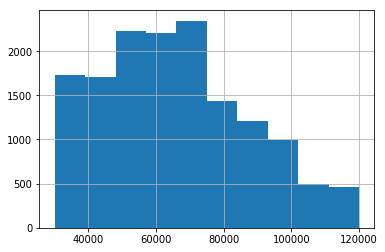

In [13]:
#check income distribution 
profile.income.hist()

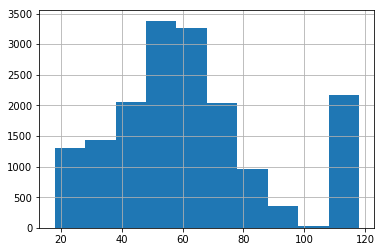

In [14]:
#check distribution of age
profile.age.hist()

In [15]:
profile.loc[profile['age']>100].age.unique()

array([118, 101])

In [16]:
profile.loc[profile['age']==101].count()

age                 5
became_member_on    5
gender              5
id                  5
income              5
dtype: int64

In [17]:
profile.loc[profile['age']==118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

In [18]:
profile.loc[profile['age']==118].income.unique()

array([ nan])

In [19]:
profile.loc[profile['age']==118].gender.unique()

array([None], dtype=object)

In [20]:
# the records for age=118 and income and gender null don't make sense, so drop
df_profile=profile.copy(deep=True)
df_profile = df_profile.loc[~df_profile['gender'].isna(),:]
df_profile.shape

(14825, 5)

In [21]:
df_profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [22]:
current_date=pd.to_datetime("now")
#current_date=date.today()
current_date

Timestamp('2021-02-05 01:09:34.782202')

In [23]:
df_profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [24]:
# convert column of 'became_member_on' to date
df_profile['became_member_on']=pd.to_datetime(df_profile['became_member_on'].astype(str), format='%Y%m%d')
df_profile.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [25]:
df_profile['tenure_day'] = (current_date-df_profile['became_member_on']).dt.days
df_profile.head()

,age,became_member_on,gender,id,income,tenure_day
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1301
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1368
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,1016
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,1092
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1182


In [26]:
# create profile_clean dataset with all profiles including nulls
profile_clean=profile.copy(deep=True)
profile_clean['became_member_on']=pd.to_datetime(profile_clean['became_member_on'].astype(str), format='%Y%m%d')
profile_clean['tenure_day'] = (current_date-profile_clean['became_member_on']).dt.days
profile_clean.head()

,age,became_member_on,gender,id,income,tenure_day
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1454
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1301
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,939
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1368
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,1281


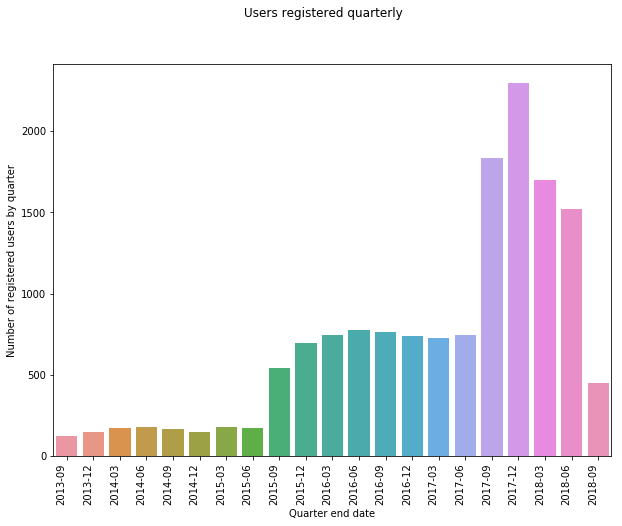

In [27]:
#Distribution of member registration by month for all users
member_month = df_profile.set_index('became_member_on').groupby(pd.Grouper(freq='Q')).count()
month_bins = member_month.index.strftime("%Y-%m")
date_format = mdates.DateFormatter("%Y-%M")
fig,ax = plt.subplots(1,1,figsize=(10,8));
fig.autofmt_xdate(rotation=90)
sns.barplot(x=month_bins, y=member_month['id'], ax=ax);
fig.suptitle('Users registered quarterly');
ax.set_xlabel('Quarter end date');
ax.set_ylabel('Number of registered users by quarter');

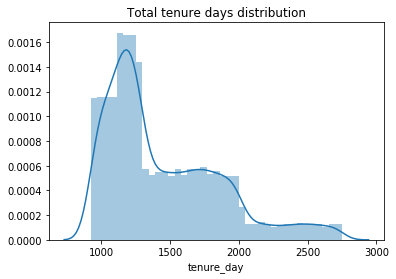

In [28]:
# distribution of age
fig_tenure = sns.distplot(df_profile['tenure_day']);
fig_tenure.set_title('Total tenure days distribution');

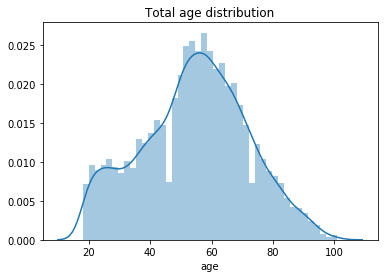

In [29]:
# distribution of age
fig_age = sns.distplot(df_profile['age']);
fig_age.set_title('Total age distribution');

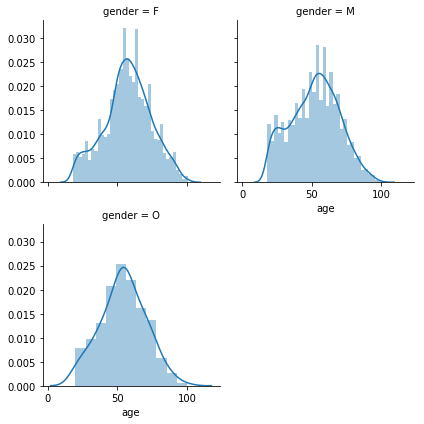

In [30]:
# age distribution by gender
fig = sns.FacetGrid(df_profile, col='gender', col_wrap=2)
fig.map(sns.distplot, 'age');

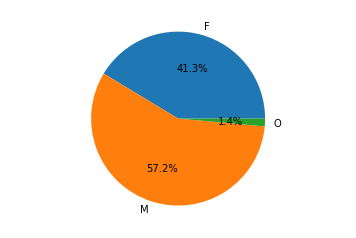

In [31]:
#gender distribution
nums = df_profile.groupby('gender').count()
plt.axis('equal')
plt.pie(nums['id'].values, labels=nums.index, autopct='%.1f%%');

## 3. Transcript

In [32]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [33]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [34]:
transcript.groupby(['person','time','event']).count().head(30)

value
person                           time event                 
0009655768c64bdeb2e877511632db8f 168  offer received       1
                                 192  offer viewed         1
                                 228  transaction          1
                                 336  offer received       1
                                 372  offer viewed         1
                                 408  offer received       1
                                 414  offer completed      1
                                      transaction          1
                                 456  offer viewed         1
                                 504  offer received       1
                                 528  offer completed      1
                                      transaction          1
                                 540  offer viewed         1
                                 552  transaction          1
                                 576  offer completed      1
                                      offer received       1
                                      transaction          1
                                 660  transaction          1
                                 690  transaction          1
                                 696  transaction          1
00116118485d4dfda04fdbaba9a87b5c 168  offer received       1
                                 216  offer viewed         1
                                 294  transaction          1
                                 456  transaction          1
                                 474  transaction          1
                                 576  offer received       1
                                 630  offer viewed         1
0011e0d4e6b944f998e987f904e8c1e5 0    offer received       1
                                 6    offer viewed         1
                                 132  transaction          1

In [35]:
transcript.value.value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

In [36]:
transcript.value.unique

<bound method Series.unique of 0          {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2          {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3          {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4          {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5          {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6          {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7          {'offer id': '3f207df678b143eea3cee63160fa8bed'}
8          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
10         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
11         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
12         {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
13         {'offer id': '3f207df678b143eea3cee63160fa8bed'}
14         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
15         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
16       

In [37]:
transcript[transcript['event']=='transaction'].head(20)

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}
12678,transaction,629fc02d56414d91bca360decdfa9288,0,{'amount': 33.9}
12686,transaction,bbeb54e861614fc7b22a8844f72dca6c,0,{'amount': 0.22}
12687,transaction,a97e6f33219c432db82acfa0d19c602d,0,{'amount': 18.59}
12691,transaction,676506bad68e4161b9bbaffeb039626b,0,{'amount': 18.01}
12696,transaction,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'amount': 19.11}


In [38]:
transcript[transcript['event']=='offer received'].head(20)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [39]:
transcript[transcript['event']=='offer viewed'].head(20)

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12656,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
12660,offer viewed,8c7df0c393db488aac3e58b06a7ea5f9,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
12661,offer viewed,e528ceb341964128aaf58a59733ec2af,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
12662,offer viewed,262ad0fb526a4d53b572007da60cce24,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12663,offer viewed,53bac762af27471eb294ff89ca1bae2c,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


In [40]:
transcript[transcript['event']=='offer completed']['value'].head(20)

12658    {'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679    {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692    {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697    {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
12717    {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
12721    {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
12744    {'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
12764    {'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12767    {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
12780    {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12784    {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12786    {'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12798    {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12817    {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
12826    {'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12835    {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2.

In [41]:
df_transcript=transcript.copy(deep=True)

In [42]:
#df_transcript = pd.get_dummies(df_transcript , columns=['event'] , prefix='' ,prefix_sep='')
#df_transcript.head()

In [43]:
# find when event== offer completed, with more than 1 value keys
df_transcript['value_keys'] = df_transcript['value'].apply(lambda x: list(x.keys()))
df_transcript['num_value_keys'] = df_transcript['value'].apply(lambda x: len(x.keys()))
print("Events with more than 1 value key: ", df_transcript.loc[df_transcript['num_value_keys']>1,'event'].unique())
df_transcript.loc[df_transcript['num_value_keys']>1].iloc[:2,:]

Events with more than 1 value key:  ['offer completed']


,event,person,time,value,value_keys,num_value_keys
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,"[offer_id, reward]",2
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,"[offer_id, reward]",2


In [44]:
# offer id and offer_id should be the same key


In [45]:
df_transcript.head(10)

,event,person,time,value,value_keys,num_value_keys
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},[offer id],1
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},[offer id],1
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},[offer id],1
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},[offer id],1
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},[offer id],1
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},[offer id],1
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},[offer id],1
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},[offer id],1
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},[offer id],1
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},[offer id],1


In [46]:
def value_return(df, original_key):
    """
    Input:
        df: dataframe
        original_keys: list of original keys
    Output:
        key: string or nan
    """
    for key in df['value_keys']:
        if key in original_key:
            return df['value'][key]
    return np.nan

offer_id = df_transcript.loc[:,['value_keys','value']].apply(value_return, axis=1, original_key=['offer_id', 'offer id'])
amount = df_transcript.loc[:,['value_keys','value']].apply(value_return, axis=1, original_key=['amount'])
reward = df_transcript.loc[:,['value_keys','value']].apply(value_return, axis=1, original_key=['reward'])

In [47]:
df_transcript['offer_id'] = offer_id
df_transcript['amount'] = amount
df_transcript['reward'] = reward

In [48]:
df_transcript

,event,person,time,value,value_keys,num_value_keys,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},[offer id],1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},[offer id],1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},[offer id],1,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},[offer id],1,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},[offer id],1,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},[offer id],1,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},[offer id],1,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},[offer id],1,3f207df678b143eea3cee63160fa8bed,NaN,NaN
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},[offer id],1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},[offer id],1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN


In [49]:
df_transcript_clean = df_transcript.drop(columns=['value', 'value_keys', 'num_value_keys'])
df_transcript_clean.head()

,event,person,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [50]:
df_transcript_clean.tail()

,event,person,time,offer_id,amount,reward
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,NaN,1.59,NaN
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,NaN,9.53,NaN
306531,transaction,a00058cf10334a308c68e7631c529907,714,NaN,3.61,NaN
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,NaN,3.53,NaN
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,NaN,4.05,NaN


In [51]:
df_transcript_clean.offer_id.unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837', nan], dtype=object)

In [52]:
df_portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [53]:
df_portfolio['duration']=df_portfolio['duration']*24
df_portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [54]:
# merge transcript and portfolio
df_trans_folio=pd.merge(df_transcript_clean,df_portfolio, how='left',on=['offer_id'])
df_trans_folio.rename(columns={"reward_x":"actual_reward","reward_y":"offer_reward"}, inplace=True)
df_trans_folio.head()

,event,person,time,offer_id,amount,actual_reward,difficulty,duration,offer_type,offer_reward,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5.0,168.0,bogo,5.0,1.0,1.0,0.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,20.0,240.0,discount,5.0,1.0,0.0,0.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,10.0,168.0,discount,2.0,1.0,1.0,0.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,10.0,240.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,10.0,120.0,bogo,10.0,1.0,1.0,1.0,1.0


In [55]:
df_trans_folio[df_trans_folio['event']=="offer completed"].head()

,event,person,time,offer_id,amount,actual_reward,difficulty,duration,offer_type,offer_reward,email,mobile,social,web
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,168.0,discount,2.0,1.0,1.0,0.0,1.0
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,10.0,240.0,discount,2.0,1.0,1.0,1.0,1.0
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,168.0,bogo,5.0,1.0,1.0,0.0,1.0
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,10.0,10.0,168.0,bogo,10.0,1.0,1.0,1.0,0.0
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,10.0,120.0,bogo,10.0,1.0,1.0,1.0,1.0


In [56]:
df_trans_folio[df_trans_folio['person']=="9fa9ae8f57894cc9a3b8a9bbe0fc1b2f"]

,event,person,time,offer_id,amount,actual_reward,difficulty,duration,offer_type,offer_reward,email,mobile,social,web
36,offer received,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,10.0,168.0,discount,2.0,1.0,1.0,0.0,1.0
12656,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,10.0,168.0,discount,2.0,1.0,1.0,0.0,1.0
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,34.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,168.0,discount,2.0,1.0,1.0,0.0,1.0
27850,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,42,NaN,21.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44327,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,114,NaN,32.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51350,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,156,NaN,19.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65854,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,168,NaN,20.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81403,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,204,NaN,31.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110866,offer received,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,336,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,7.0,168.0,discount,3.0,1.0,1.0,1.0,1.0


In [57]:
df_trans_folio[df_trans_folio['person']=="fe97aa22dd3e48c8b143116a8403dd52"]

,event,person,time,offer_id,amount,actual_reward,difficulty,duration,offer_type,offer_reward,email,mobile,social,web
107,offer received,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,10.0,240.0,discount,2.0,1.0,1.0,1.0,1.0
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,NaN,18.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,10.0,240.0,discount,2.0,1.0,1.0,1.0,1.0
15578,offer viewed,fe97aa22dd3e48c8b143116a8403dd52,6,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,10.0,240.0,discount,2.0,1.0,1.0,1.0,1.0
24238,transaction,fe97aa22dd3e48c8b143116a8403dd52,30,NaN,13.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38230,transaction,fe97aa22dd3e48c8b143116a8403dd52,84,NaN,16.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39554,transaction,fe97aa22dd3e48c8b143116a8403dd52,90,NaN,13.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53283,offer received,fe97aa22dd3e48c8b143116a8403dd52,168,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0
79443,offer viewed,fe97aa22dd3e48c8b143116a8403dd52,198,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0
79444,transaction,fe97aa22dd3e48c8b143116a8403dd52,198,NaN,28.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
df_profile.head()

,age,became_member_on,gender,id,income,tenure_day
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1301
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1368
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,1016
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,1092
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1182


In [59]:
# merge transcript_portfolio and profile
df_merge=pd.merge(df_trans_folio,profile_clean, left_on='person', right_on='id', how='left')
df_merge.head()

,event,person,time,offer_id,amount,actual_reward,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,age,became_member_on,gender,id,income,tenure_day
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5.0,168.0,bogo,5.0,1.0,1.0,0.0,1.0,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1368
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,20.0,240.0,discount,5.0,1.0,0.0,0.0,1.0,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,1281
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,10.0,168.0,discount,2.0,1.0,1.0,0.0,1.0,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,1016
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,10.0,240.0,discount,2.0,1.0,1.0,1.0,1.0,118,2017-09-25,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,1229
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,10.0,120.0,bogo,10.0,1.0,1.0,1.0,1.0,118,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,NaN,1222


In [60]:
df_merge.shape

(306534, 20)

# What journey after a customer receive an offer?

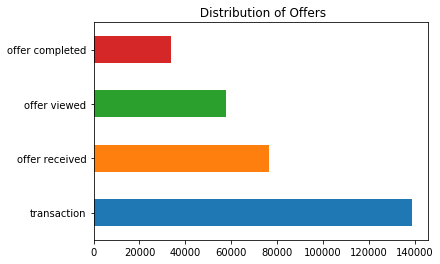

In [61]:
df_merge['event'].value_counts().plot.barh(title=' Distribution of Offers')

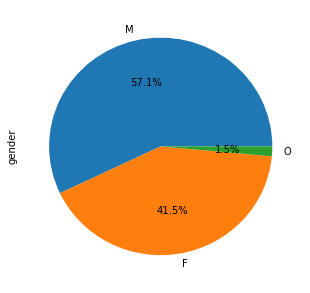

In [62]:
df_merge.gender.value_counts().plot(kind='pie' , figsize=(5, 5), autopct='%1.1f%%')

In [63]:
df_offer=df_merge[df_merge['event']!='transaction']
df_offer.event.value_counts()

offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64

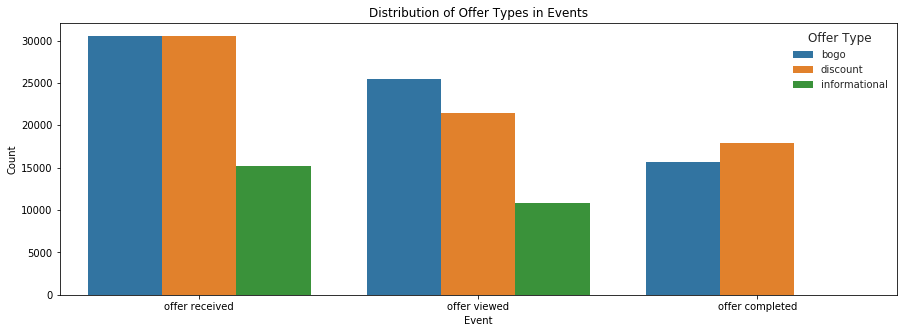

In [64]:
# Actions in each offer type:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "offer_type", data=df_offer)
sns.set(style="whitegrid")
plt.title('Distribution of Offer Types in Events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Offer Type')

### From above figures we leaned that about half of the offer received are completed and about 75% of the offers are reviewed. For the offers that are not viewed but completed, we should exclude them from offer completed because those customers would buy anyways even without offers. So we should label those offers received and proactively viewed and completed as 1 and the others as 0. Since informational offer don't have offer completed. So next we only take BOGO offer and discount offer.

# Part 1: Predict if Bogo or discount offers received would lead to offer completed

### Offer Completed Journey: offer received-offer viewed-transaction-offer completed   

### Other journey as offer not completed: 
                      1) offer received-transaction-offer completed
                      2) offer received-offer reviewed-transaction
                      3) offer received-offer reviewed
                      4) offer received-transaction
                      5) offer received   
                      

## 1.1 Prepare dataset for received  offers of BOGO and discount

In [65]:
# only take discount offer and BOGO offer
df_discount_offer=df_merge[df_merge['offer_type']!='informational']
df_discount_offer.event.value_counts()

transaction        138953
offer received      61042
offer viewed        46894
offer completed     33579
Name: event, dtype: int64

In [66]:
# sort by person and time in cleaned transcript dataset
df_discount_offer=df_discount_offer.sort_values(['person','time'])
df_discount_offer.head()

,event,person,time,offer_id,amount,actual_reward,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,age,became_member_on,gender,id,income,tenure_day
89291,transaction,0009655768c64bdeb2e877511632db8f,228,NaN,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386
153401,offer received,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386
168412,transaction,0009655768c64bdeb2e877511632db8f,414,NaN,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386


In [67]:
df_discount_offer['pre_event']=df_discount_offer.groupby('person')['event'].shift()
df_discount_offer['post_event']=df_discount_offer.groupby('person')['event'].shift(-1)
df_discount_offer['post_offer_id']=df_discount_offer.groupby('person')['offer_id'].shift(-1)
df_discount_offer['pre_pre_event']=df_discount_offer.groupby('person')['event'].shift(2)
df_discount_offer['pre_pre_time']=df_discount_offer.groupby('person')['time'].shift(2)
df_transcript_discount_offer=df_discount_offer[['event','person','time','offer_id','amount'\
                                                ,'actual_reward','pre_event','post_event','post_offer_id'\
                                                ,'pre_pre_event','pre_pre_time']]
df_transcript_discount_offer.head()

,event,person,time,offer_id,amount,actual_reward,pre_event,post_event,post_offer_id,pre_pre_event,pre_pre_time
89291,transaction,0009655768c64bdeb2e877511632db8f,228,NaN,22.16,NaN,NaN,offer received,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
153401,offer received,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,transaction,transaction,NaN,NaN,NaN
168412,transaction,0009655768c64bdeb2e877511632db8f,414,NaN,8.57,NaN,offer received,offer completed,f19421c1d4aa40978ebb69ca19b0e20d,transaction,228.0
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,transaction,offer viewed,f19421c1d4aa40978ebb69ca19b0e20d,offer received,408.0
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,offer completed,offer received,fafdcd668e3743c1bb461111dcafc2a4,transaction,414.0


In [68]:
# find only completed transactions
df_completed_offer_transaction=df_transcript_discount_offer[df_transcript_discount_offer['event']=='transaction']
df_completed_offer_transaction=df_completed_offer_transaction[df_completed_offer_transaction['post_event']=='offer completed']
df_completed_offer_transaction=df_completed_offer_transaction.drop('offer_id', axis=1)
df_completed_offer_transaction=df_completed_offer_transaction.rename(columns={'post_offer_id': 'offer_id'})
df_completed_offer_transaction.head()

,event,person,time,amount,actual_reward,pre_event,post_event,offer_id,pre_pre_event,pre_pre_time
168412,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,NaN,offer received,offer completed,f19421c1d4aa40978ebb69ca19b0e20d,transaction,228.0
228422,transaction,0009655768c64bdeb2e877511632db8f,528,14.11,NaN,offer received,offer completed,fafdcd668e3743c1bb461111dcafc2a4,offer viewed,456.0
258883,transaction,0009655768c64bdeb2e877511632db8f,576,10.27,NaN,offer received,offer completed,2906b810c7d4411798c6938adc9daaa5,transaction,552.0
95421,transaction,0011e0d4e6b944f998e987f904e8c1e5,252,11.93,NaN,offer viewed,offer completed,2298d6c36e964ae4a3e7e9706d1fb8c2,offer received,168.0
258979,transaction,0011e0d4e6b944f998e987f904e8c1e5,576,22.05,NaN,offer viewed,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,504.0


In [69]:
# find transaction offers that has journey of 'offer received'-'offer viewed'-'transaction'-'offer completed'
df_proactive_completed_offer=df_completed_offer_transaction[(df_completed_offer_transaction['pre_pre_event']=='offer received') & (df_completed_offer_transaction['pre_event']=='offer viewed')]
#df_proactive_completed_offer=df_completed_offer_transaction[(df_completed_offer_transaction['pre_event']=='offer viewed')]
df_proactive_completed_offer.head()

,event,person,time,amount,actual_reward,pre_event,post_event,offer_id,pre_pre_event,pre_pre_time
95421,transaction,0011e0d4e6b944f998e987f904e8c1e5,252,11.93,NaN,offer viewed,offer completed,2298d6c36e964ae4a3e7e9706d1fb8c2,offer received,168.0
258979,transaction,0011e0d4e6b944f998e987f904e8c1e5,576,22.05,NaN,offer viewed,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,504.0
31326,transaction,0020c2b971eb4e9188eac86d93036a77,54,17.63,NaN,offer viewed,offer completed,fafdcd668e3743c1bb461111dcafc2a4,offer received,0.0
218935,transaction,0020c2b971eb4e9188eac86d93036a77,510,17.24,NaN,offer viewed,offer completed,fafdcd668e3743c1bb461111dcafc2a4,offer received,408.0
88009,transaction,0020ccbbb6d84e358d3414a3ff76cffd,222,11.65,NaN,offer viewed,offer completed,2298d6c36e964ae4a3e7e9706d1fb8c2,offer received,168.0


In [70]:
# Get offer received which leads to offer viewed-transaction-offer completed
df_offer_received_completed=df_proactive_completed_offer[['person','offer_id','pre_pre_event','pre_pre_time']]
df_offer_received_completed.rename(columns={'pre_pre_time':'time'},inplace=True)
df_offer_received_completed=df_offer_received_completed.astype({'time': 'int64'})

# get all discount and bogo offer received
df_received=df_discount_offer[df_discount_offer['event']=='offer received']
df_received.drop(['pre_pre_time','pre_pre_event','pre_event','post_event','post_offer_id','became_member_on','amount','actual_reward'],axis=1,inplace=True)
df_received.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,event,person,time,offer_id,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,age,gender,id,income,tenure_day
153401,offer received,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,33,M,0009655768c64bdeb2e877511632db8f,72000.0,1386
204340,offer received,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,10.0,240.0,discount,2.0,1.0,1.0,1.0,1.0,33,M,0009655768c64bdeb2e877511632db8f,72000.0,1386
247879,offer received,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,10.0,168.0,discount,2.0,1.0,1.0,0.0,1.0,33,M,0009655768c64bdeb2e877511632db8f,72000.0,1386
56475,offer received,00116118485d4dfda04fdbaba9a87b5c,168,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,118,None,00116118485d4dfda04fdbaba9a87b5c,NaN,1017
248359,offer received,00116118485d4dfda04fdbaba9a87b5c,576,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,118,None,00116118485d4dfda04fdbaba9a87b5c,NaN,1017


## 1.2 Data Exploration for bogo or discount offers received

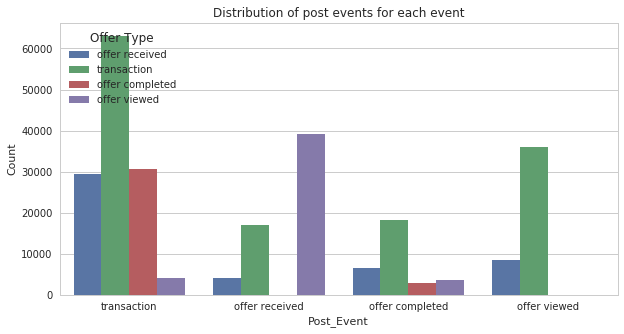

In [71]:
#Plot distribution of the completed transactions after reviewing offer:
plt.figure(figsize=(10, 5))
sns.countplot(x= "event", hue= "post_event", data=df_transcript_discount_offer)
sns.set(style="whitegrid")
plt.title('Distribution of post events for each event')
plt.ylabel('Count')
plt.xlabel('Post_Event')
plt.legend(title='Offer Type')

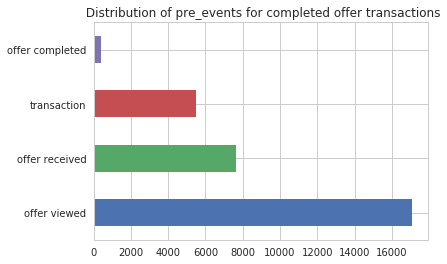

In [72]:
# distribution of events before completed offer transactions
df_completed_offer_transaction['pre_event'].value_counts().plot.barh(title=' Distribution of pre_events for completed offer transactions')

In [73]:
# merge df_offer_received_completed with df_received

df_received_offer=pd.merge(df_received, df_offer_received_completed, how='left', on=['person','time','offer_id'])
df_received_offer.head()

,event,person,time,offer_id,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,age,gender,id,income,tenure_day,pre_pre_event
0,offer received,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,33,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,NaN
1,offer received,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,10.0,240.0,discount,2.0,1.0,1.0,1.0,1.0,33,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,NaN
2,offer received,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,10.0,168.0,discount,2.0,1.0,1.0,0.0,1.0,33,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,NaN
3,offer received,00116118485d4dfda04fdbaba9a87b5c,168,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,118,None,00116118485d4dfda04fdbaba9a87b5c,NaN,1017,NaN
4,offer received,00116118485d4dfda04fdbaba9a87b5c,576,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,118,None,00116118485d4dfda04fdbaba9a87b5c,NaN,1017,NaN


In [74]:
# Flag offer received followed with offer viewed-transaction-offer completed
df_received_offer['completed_offer']=np.where(df_received_offer['pre_pre_event']=='offer received','yes','no')
df_received_offer.tail()

,event,person,time,offer_id,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,age,gender,id,income,tenure_day,pre_pre_event,completed_offer
61037,offer received,ffff82501cea40309d5fdd7edcca4a07,168,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,240.0,discount,5.0,1.0,0.0,0.0,1.0,45,F,ffff82501cea40309d5fdd7edcca4a07,62000.0,1533,offer received,yes
61038,offer received,ffff82501cea40309d5fdd7edcca4a07,336,2906b810c7d4411798c6938adc9daaa5,10.0,168.0,discount,2.0,1.0,1.0,0.0,1.0,45,F,ffff82501cea40309d5fdd7edcca4a07,62000.0,1533,offer received,yes
61039,offer received,ffff82501cea40309d5fdd7edcca4a07,408,2906b810c7d4411798c6938adc9daaa5,10.0,168.0,discount,2.0,1.0,1.0,0.0,1.0,45,F,ffff82501cea40309d5fdd7edcca4a07,62000.0,1533,offer received,yes
61040,offer received,ffff82501cea40309d5fdd7edcca4a07,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,168.0,bogo,5.0,1.0,1.0,0.0,1.0,45,F,ffff82501cea40309d5fdd7edcca4a07,62000.0,1533,NaN,no
61041,offer received,ffff82501cea40309d5fdd7edcca4a07,576,2906b810c7d4411798c6938adc9daaa5,10.0,168.0,discount,2.0,1.0,1.0,0.0,1.0,45,F,ffff82501cea40309d5fdd7edcca4a07,62000.0,1533,NaN,no


In [75]:
# final dataset for offer received flag with offer completed
df_received_flag=df_received_offer.drop(columns=['event','pre_pre_event'])
df_received_flag.head()

,person,time,offer_id,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,age,gender,id,income,tenure_day,completed_offer
0,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,33,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,no
1,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,10.0,240.0,discount,2.0,1.0,1.0,1.0,1.0,33,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,no
2,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,10.0,168.0,discount,2.0,1.0,1.0,0.0,1.0,33,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,no
3,00116118485d4dfda04fdbaba9a87b5c,168,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,118,None,00116118485d4dfda04fdbaba9a87b5c,NaN,1017,no
4,00116118485d4dfda04fdbaba9a87b5c,576,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,118,None,00116118485d4dfda04fdbaba9a87b5c,NaN,1017,no


In [76]:
df_received_flag['gender'] = df_received_flag['gender'].replace([None], ['unknown'], regex=True)
df_received_flag['income']= df_received_flag['income'].fillna(0)


In [77]:
df_received_flag.isna().sum()

person             0
time               0
offer_id           0
difficulty         0
duration           0
offer_type         0
offer_reward       0
email              0
mobile             0
social             0
web                0
age                0
gender             0
id                 0
income             0
tenure_day         0
completed_offer    0
dtype: int64

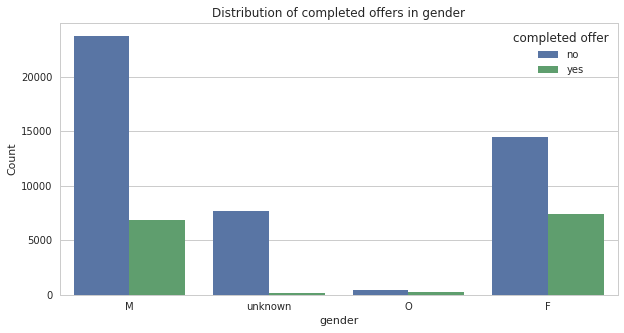

In [78]:
# completed offer distribution in gender
plt.figure(figsize=(10, 5))
sns.countplot(x= "gender", hue= "completed_offer", data=df_received_flag)
sns.set(style="whitegrid")
plt.title('Distribution of completed offers in gender')
plt.ylabel('Count')
plt.xlabel('gender')
plt.legend(title='completed offer')

### Observation1: Female customers respond better than males with bogo or discount offer.
### Observation2: Customers who don't fill in the sex rarely respond with bogo or discount offer.

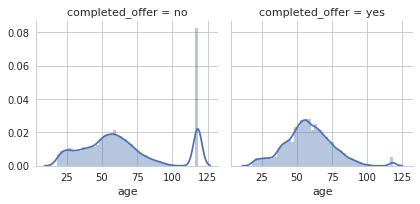

In [79]:
# age distribution by completed offer
fig = sns.FacetGrid(df_received_flag, col='completed_offer', col_wrap=2)
fig.map(sns.distplot, 'age');

### Observation 3: Customers who filled age with 118 rarely respond to discount or bogo offers.

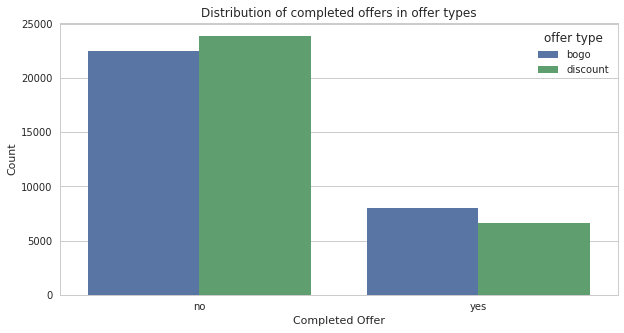

In [80]:
# completed offer distribution in offer type
plt.figure(figsize=(10, 5))
sns.countplot(x= "completed_offer", hue= "offer_type", data=df_received_flag)
sns.set(style="whitegrid")
plt.title('Distribution of completed offers in offer types')
plt.ylabel('Count')
plt.xlabel('Completed Offer')
plt.legend(title='offer type')

### Observation 4: A little more bogo offers are completed.

In [81]:
# only 160 out of 7841 of offers completed from customers who didn't fill in gender
df_unknown=df_received_flag[df_received_flag['gender']=='unknown']
df_unknown.completed_offer.value_counts()

no     7681
yes     160
Name: completed_offer, dtype: int64

In [82]:
df1=df_received_flag.copy(deep=True)
df1.head()

,person,time,offer_id,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,age,gender,id,income,tenure_day,completed_offer
0,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,33,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,no
1,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,10.0,240.0,discount,2.0,1.0,1.0,1.0,1.0,33,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,no
2,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,10.0,168.0,discount,2.0,1.0,1.0,0.0,1.0,33,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,no
3,00116118485d4dfda04fdbaba9a87b5c,168,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,118,unknown,00116118485d4dfda04fdbaba9a87b5c,0.0,1017,no
4,00116118485d4dfda04fdbaba9a87b5c,576,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,118,unknown,00116118485d4dfda04fdbaba9a87b5c,0.0,1017,no


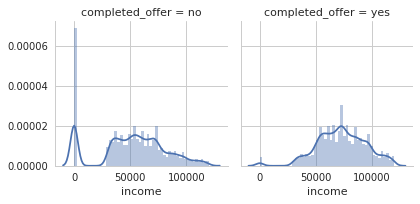

In [83]:
# income distribution by offer completed or not
fig = sns.FacetGrid(df_received_flag, col='completed_offer', col_wrap=2)
fig.map(sns.distplot, 'income');

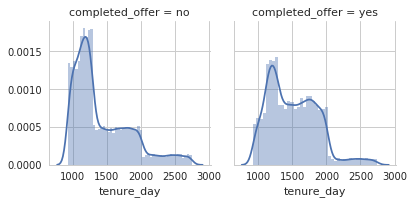

In [84]:
# age distribution by gender
fig = sns.FacetGrid(df_received_flag, col='completed_offer', col_wrap=2)
fig.map(sns.distplot, 'tenure_day');

In [85]:
def cleaning_profile(df):
    """
    Clean the profile data frame as per tasks 2-4
        
    Parameters
    ----------   
    df: data frame
    
    Returns
    -------
    df: output data frame as per tasks
    """

    #replace missing gender values with mode i.e. most frequent gender
    #mode = df['gender'].mode()[0]
    #df['gender'] = df['gender'].fillna(mode)
    # add income_group column
    df.loc[(df.income ==0.0) , 'income_group'] = 'unknown'
    df.loc[(df.income <= 50000)& (df.income > 0.0) , 'income_group'] = 'LowIncome'
    df.loc[(df.income >= 50000) & (df.income < 75000) , 'income_group'] = 'MiddleIncome'
    df.loc[(df.income >= 75000) & (df.income < 100000) , 'income_group'] = 'MiddleHighIncome'
    df.loc[(df.income >= 100000)  , 'income_group'] = 'HighIncome'

    
    # add Age_group column
    
    df.loc[(df.age < 20) , 'age_group'] = '20_under'
    df.loc[(df.age >= 20) & (df.age < 35) , 'age_group'] = '20-35'
    df.loc[(df.age >= 35) & (df.age < 50) , 'age_group'] = '35-50'
    df.loc[(df.age >= 50) & (df.age < 65) , 'age_group'] = '50-65'
    df.loc[(df.age >= 65) & (df.age < 80) , 'age_group'] = '65-80'
    df.loc[(df.age >= 80) & (df.age < 95) , 'age_group'] = '80-95'
    df.loc[(df.age >= 95) & (df.age < 118), 'age_group'] = '95_above'
    df.loc[(df.age ==118) , 'age_group'] = 'unknown'
    
        # add tenure_group column
    df.loc[(df.tenure_day < 1000) , 'tenure_group'] = '1000_Under'
    df.loc[(df.tenure_day >= 1000) & (df.tenure_day < 1125) , 'tenure_group'] = '1000-1125'
    df.loc[(df.tenure_day >= 1125) & (df.tenure_day < 1250) , 'tenure_group'] = '1125-1250'
    df.loc[(df.tenure_day>= 1250) & (df.tenure_day < 1500) , 'tenure_group'] = '1250-1500'
    df.loc[(df.tenure_day >= 1500) & (df.tenure_day < 2000) , 'tenure_group'] = '1500-2000'
    df.loc[(df.age >= 2000) , 'tenure_group'] = '2000_above'
    #df.drop('age',axis=1,inplace=True)
    return df

In [86]:
df1=cleaning_profile(df1)
df1.head()

,person,time,offer_id,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,age,gender,id,income,tenure_day,completed_offer,income_group,age_group,tenure_group
0,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,33,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,no,MiddleIncome,20-35,1250-1500
1,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,10.0,240.0,discount,2.0,1.0,1.0,1.0,1.0,33,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,no,MiddleIncome,20-35,1250-1500
2,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,10.0,168.0,discount,2.0,1.0,1.0,0.0,1.0,33,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,no,MiddleIncome,20-35,1250-1500
3,00116118485d4dfda04fdbaba9a87b5c,168,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,118,unknown,00116118485d4dfda04fdbaba9a87b5c,0.0,1017,no,unknown,unknown,1000-1125
4,00116118485d4dfda04fdbaba9a87b5c,576,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,118,unknown,00116118485d4dfda04fdbaba9a87b5c,0.0,1017,no,unknown,unknown,1000-1125


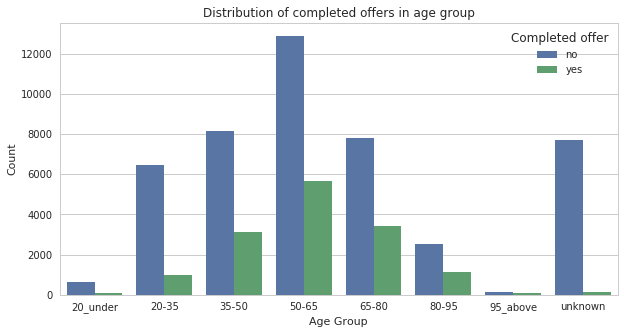

In [87]:
# completed offer distribution in offer type
plt.figure(figsize=(10, 5))
sns.countplot(x= "age_group", hue= 'completed_offer', data=df1,order=['20_under','20-35','35-50','50-65','65-80','80-95','95_above','unknown'])
sns.set(style="darkgrid")
plt.title('Distribution of completed offers in age group')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Completed offer')

### Observation 5: Senior customers complete offers more than young customers, especially for customers older than 50.
### Observation 6: Customers who filled with age 118, 'unknown' here, rarely complete offers.

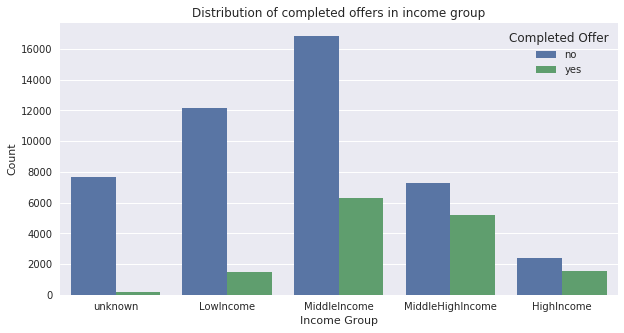

In [88]:
# completed offer distribution in offer type
plt.figure(figsize=(10, 5))
sns.countplot(x= "income_group", hue= 'completed_offer', data=df1, order=['unknown','LowIncome','MiddleIncome','MiddleHighIncome','HighIncome'])
sns.set(style="darkgrid")
plt.title('Distribution of completed offers in income group')
plt.ylabel('Count')
plt.xlabel('Income Group')
plt.legend(title='Completed Offer')

### Observation 7: Customers who have higher income has better ratio of completing an offer.
### Observation 8: Customers with unknown income don't respond an offer well.

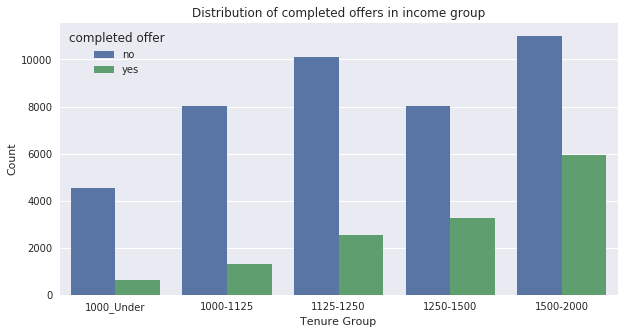

In [89]:
# completed offer distribution in offer type
plt.figure(figsize=(10, 5))
sns.countplot(x= "tenure_group", hue= 'completed_offer', data=df1, order=['1000_Under','1000-1125','1125-1250','1250-1500','1500-2000'])
sns.set(style="darkgrid")
plt.title('Distribution of completed offers in income group')
plt.ylabel('Count')
plt.xlabel('Tenure Group')
plt.legend(title='completed offer')

### Observation 9: Customers with longer tenure days respond to an offer better.

## 1.2 Build models to predict if the received offer with bogo or discount would be completed

## 1.2.1 Feature Engineering

In [90]:
# add number of offers received before current offer
df_received_flag["RANK"] = df_received_flag.groupby(['person'])["time"].rank(method="first", ascending=True)
df_received_flag["Num_of_offer_received"]=df_received_flag["RANK"]-1.0

df_received_flag.head()

,person,time,offer_id,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,age,gender,id,income,tenure_day,completed_offer,RANK,Num_of_offer_received
0,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,33,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,no,1.0,0.0
1,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,10.0,240.0,discount,2.0,1.0,1.0,1.0,1.0,33,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,no,2.0,1.0
2,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,10.0,168.0,discount,2.0,1.0,1.0,0.0,1.0,33,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,no,3.0,2.0
3,00116118485d4dfda04fdbaba9a87b5c,168,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,118,unknown,00116118485d4dfda04fdbaba9a87b5c,0.0,1017,no,1.0,0.0
4,00116118485d4dfda04fdbaba9a87b5c,576,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,118,unknown,00116118485d4dfda04fdbaba9a87b5c,0.0,1017,no,2.0,1.0


In [91]:
#check for class balance in datasets
print(df_received_flag[['person','completed_offer']].groupby('completed_offer').count()/len(df_received_flag))

                   person
completed_offer          
no               0.758953
yes              0.241047


In [92]:
#final dataset for bogo and discount offers:
df=df_received_flag.drop(columns=['person','id','RANK'])
df.head()

,time,offer_id,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,age,gender,income,tenure_day,completed_offer,Num_of_offer_received
0,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,33,M,72000.0,1386,no,0.0
1,504,fafdcd668e3743c1bb461111dcafc2a4,10.0,240.0,discount,2.0,1.0,1.0,1.0,1.0,33,M,72000.0,1386,no,1.0
2,576,2906b810c7d4411798c6938adc9daaa5,10.0,168.0,discount,2.0,1.0,1.0,0.0,1.0,33,M,72000.0,1386,no,2.0
3,168,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,118,unknown,0.0,1017,no,0.0
4,576,f19421c1d4aa40978ebb69ca19b0e20d,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,118,unknown,0.0,1017,no,1.0


In [93]:
# dummy variable encoding function
def dummy(df,col):
    """
    inputs:
     - df: dataframe
     - col: column name
    outputs:
     - df: dataframe with new dummy columns
     
    """
    df=pd.concat([df[:],pd.get_dummies(df[col],prefix=col)],axis=1)
    df=df.drop(columns=col,inplace=False)
    return df

In [94]:
# split unique gender and offer_type to dummy variables 
df= dummy(df,'gender')
df=dummy(df,'offer_type')

#Process offer_id column:
list_offer_ids = df['offer_id'].unique().tolist()
offer_id_mapping = dict( zip(list_offer_ids,range(len(list_offer_ids))) )
df.replace({'offer_id': offer_id_mapping},inplace=True)

#process numerical variables
#initialize a MinMaxScaler, then apply it to the numerical features
scaler = MinMaxScaler() # default=(0, 1)
num_cols = ['time', 'difficulty', 'duration', 'offer_reward', 'age', 'income','tenure_day','Num_of_offer_received']
df[num_cols] = scaler.fit_transform(df[num_cols])

#encode 'completed_offer'  to numerical values 
df['completed_offer'] = df['completed_offer'].map({'yes':1, 'no':0})
    
df.head()


,time,offer_id,difficulty,duration,offer_reward,email,mobile,social,web,age,income,tenure_day,completed_offer,Num_of_offer_received,gender_F,gender_M,gender_O,gender_unknown,offer_type_bogo,offer_type_discount
0,0.708333,0,0.000000,0.0,0.375,1.0,1.0,1.0,1.0,0.15,0.6,0.252880,0,0.0,0,1,0,0,1,0
1,0.875000,1,0.333333,1.0,0.000,1.0,1.0,1.0,1.0,0.15,0.6,0.252880,0,0.2,0,1,0,0,0,1
2,1.000000,2,0.333333,0.4,0.000,1.0,1.0,0.0,1.0,0.15,0.6,0.252880,0,0.4,0,1,0,0,0,1
3,0.291667,0,0.000000,0.0,0.375,1.0,1.0,1.0,1.0,1.00,0.0,0.050466,0,0.0,0,0,0,1,1,0
4,1.000000,0,0.000000,0.0,0.375,1.0,1.0,1.0,1.0,1.00,0.0,0.050466,0,0.2,0,0,0,1,1,0


## 1.2.2 Model Building

In [95]:
target = df['completed_offer']
features = df.drop(columns = 'completed_offer',axis=1)

In [96]:
def model_pipeline(features,target):
    '''
    inputs:
    - features dataframe 
    - target dataframe
    
    outputs:
    - Splits features and target dataframe to train and test sets, performs feature scaling on both datasets.
    - Outputs X_train, X_test, y_train and y_test dataframes
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, test_size=0.20, random_state=15)

    #fit and transform scaling on training data
    #scaler=StandardScaler()
    #X_train=scaler.fit_transform(X_train)

    #scale test data
    #X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

In [97]:
def Score(model, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - model: the learning algorithm to be trained and predicted on
       - X_train: features in training set
       - y_train: target for training set
       - X_test: features in testing set
       - y_test: target in testing set
       
    Outputs:
       - train_f1: f1 score for training set
       - test_f1:  f1 score for testing set
       - model: name of model
    '''
    results = {}
    
    #Fit the model to the training data and get training time
    start = time() 
    model = model.fit(X_train, y_train)
    end = time() 
        # print the total prediction time
    print("training time: %.4f" % (end-start))
    
    # Get predictions for the test set(X_test)
    start = time() 
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    end = time() 
    print("testing time: %.4f" % (end-start))

    train_f1 =  accuracy_score(y_train, predictions_train)*100
    test_f1= accuracy_score(y_test, predictions_test)*100
    name = model.__class__.__name__
    
    print("Training f1 score:%.4f" % train_f1)
    print("Test f1 score:%.4f" % test_f1)
    print(classification_report(y_test, predictions_test,digits=4))
    
    return train_f1, test_f1, name
    

In [98]:
X_train,X_test,y_train, y_test=model_pipeline(features,target)

In [99]:
# baseline decision tree model:
model_DT=DecisionTreeClassifier(random_state = 42)
model_DT_train_f1, model_DT_test_f1, model_DT_model = Score(model_DT,X_train, y_train, X_test, y_test)

training time: 0.3396
testing time: 0.0229
Training f1 score:99.9898
Test f1 score:72.8807
             precision    recall  f1-score   support

          0     0.8197    0.8223    0.8210      9233
          1     0.4432    0.4388    0.4410      2976

avg / total     0.7279    0.7288    0.7284     12209



In [100]:
# random forest tree model:
#Initialize the model
model_rf = RandomForestClassifier(random_state=42,max_depth= 10, max_features= 'auto',min_samples_split= 2,n_estimators=50,min_samples_leaf=2)
model_rf_train_f1, model_rf_test_f1, model_rf_model = Score(model_rf,X_train, y_train, X_test, y_test)

training time: 2.3999
testing time: 0.4042
Training f1 score:80.1261
Test f1 score:79.2940
             precision    recall  f1-score   support

          0     0.8062    0.9559    0.8747      9233
          1     0.6775    0.2873    0.4035      2976

avg / total     0.7749    0.7929    0.7599     12209



In [101]:
#Try grid search to optimise parameters:

#define Grid Search function
def rf_param_selection(X,y):
    '''
    input:
    - X: training datasets for X (X_train)
    - y: training datasets for y (y_train)
    output:
    - dictionary with best parameters for random forest model
    '''
    
    param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [5,10,15],
                'n_estimators': [25,50,100],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [2, 3, 5]
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_


In [102]:
rf_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 25}

In [103]:
# random forest tree model:
#Initialize the model
Model_rf2 = RandomForestClassifier(random_state=42,max_depth= 10, max_features= 'auto',min_samples_split= 10,n_estimators=25,min_samples_leaf=2)
Model_rf2_train_f1, Model_rf2_rf_test_f1, Model_rf2_rf_model = Score(Model_rf2,X_train, y_train, X_test, y_test)

training time: 1.1665
testing time: 0.2063
Training f1 score:80.1876
Test f1 score:79.4414
             precision    recall  f1-score   support

          0     0.8077    0.9557    0.8755      9233
          1     0.6815    0.2940    0.4108      2976

avg / total     0.7769    0.7944    0.7622     12209



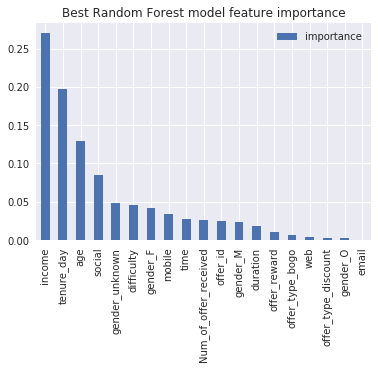

In [104]:
feature_importances = pd.DataFrame(model_rf.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best Random Forest model feature importance')
plt.show()

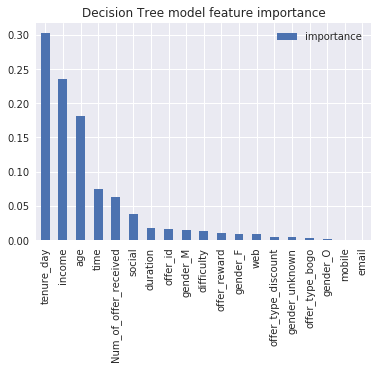

In [105]:
feature_importances = pd.DataFrame(model_DT.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Decision Tree model feature importance')
plt.show()

# Part 2: Predict if informational offers received would lead to transaction

### Effective offer journey: offer received-offer viewed-transaction within offer valid time  

### Not effective offer journey: 
                      1) offer received-transaction
                      2) offer received-offer reviewed-transaction after valid time
                      3) offer received-offer reviewed
                      4) offer received

## 2.1 Prepare dataset for received informational offers flag with effective offer

In [106]:
df_infor_offer=df_merge[~df_merge['offer_type'].isin(['bogo','discount'])]
df_infor_offer.event.value_counts()

transaction       138953
offer received     15235
offer viewed       10831
Name: event, dtype: int64

In [107]:
# sort by person and time in cleaned transcript dataset
df_infor_offer=df_infor_offer.sort_values(['person','time'])
df_infor_offer.head()

,event,person,time,offer_id,amount,actual_reward,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,age,became_member_on,gender,id,income,tenure_day
55972,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386
89291,transaction,0009655768c64bdeb2e877511632db8f,228,NaN,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386
113605,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386


In [108]:
#filter dataset for transactions that occur after an offer is viewed, forward fill offer ids by person
offer_effective = df_infor_offer[['time','offer_id','person','event']][(df_infor_offer['event']\
    =='transaction') | (df_infor_offer['event']=='offer viewed')]
offer_effective.update(offer_effective.groupby(['person']).ffill())
offer_effective['offer_id'] = offer_effective['offer_id'].ffill()
offer_effective.head()

,time,offer_id,person,event
77705,192,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,offer viewed
89291,228,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,transaction
139992,372,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,offer viewed
168412,414,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,transaction
228422,528,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,transaction


In [109]:
# merge offer_effective with df_infor_offer
df_infor_effective=pd.merge(df_infor_offer,offer_effective,on=['time','person','event'], how='left')
df_infor_effective.head()

,event,person,time,offer_id_x,amount,actual_reward,difficulty,duration,offer_type,offer_reward,...,mobile,social,web,age,became_member_on,gender,id,income,tenure_day,offer_id_y
0,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,0.0,72.0,informational,0.0,...,1.0,1.0,0.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,0.0,72.0,informational,0.0,...,1.0,1.0,0.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,NaN,22.16,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0.0,96.0,informational,0.0,...,1.0,0.0,1.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0.0,96.0,informational,0.0,...,1.0,0.0,1.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,3f207df678b143eea3cee63160fa8bed


In [110]:
# find offer id for transactions after offer viewed, forwarded off_id from the closest offer viewed, not guarantee it is the true offer
df_infor_effective['offer_id']=np.where(df_infor_effective['offer_id_x'].isnull(), df_infor_effective['offer_id_y'], df_infor_effective['offer_id_x'])
df_infor_effective.head()

,event,person,time,offer_id_x,amount,actual_reward,difficulty,duration,offer_type,offer_reward,...,social,web,age,became_member_on,gender,id,income,tenure_day,offer_id_y,offer_id
0,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,0.0,72.0,informational,0.0,...,1.0,0.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,NaN,5a8bc65990b245e5a138643cd4eb9837
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,0.0,72.0,informational,0.0,...,1.0,0.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,NaN,22.16,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0.0,96.0,informational,0.0,...,0.0,1.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,NaN,3f207df678b143eea3cee63160fa8bed
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0.0,96.0,informational,0.0,...,0.0,1.0,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1386,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed


In [111]:
df_infor_effective.drop(columns=['offer_id_x','offer_id_y','id'], inplace=True)
df_infor_effective.head()

,event,person,time,amount,actual_reward,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,age,became_member_on,gender,income,tenure_day,offer_id
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0,33,2017-04-21,M,72000.0,1386,5a8bc65990b245e5a138643cd4eb9837
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0,33,2017-04-21,M,72000.0,1386,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,2017-04-21,M,72000.0,1386,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0,33,2017-04-21,M,72000.0,1386,3f207df678b143eea3cee63160fa8bed
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0,33,2017-04-21,M,72000.0,1386,3f207df678b143eea3cee63160fa8bed


In [112]:
# only get offer received and transaction
received_transaction=df_infor_effective[df_infor_effective['event']!='offer viewed']
received_transaction.head()

,event,person,time,amount,actual_reward,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,age,became_member_on,gender,income,tenure_day,offer_id
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0,33,2017-04-21,M,72000.0,1386,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,2017-04-21,M,72000.0,1386,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0,33,2017-04-21,M,72000.0,1386,3f207df678b143eea3cee63160fa8bed
5,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,2017-04-21,M,72000.0,1386,3f207df678b143eea3cee63160fa8bed
6,transaction,0009655768c64bdeb2e877511632db8f,528,14.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,2017-04-21,M,72000.0,1386,3f207df678b143eea3cee63160fa8bed


In [113]:
# get received offer dataset
offer_received=received_transaction.loc[received_transaction['event']=='offer received'][['event','person','time','duration','offer_id']]
offer_received['receive_time']=offer_received['time']
offer_received['offer_duration']=offer_received['duration']
offer_received['received_offer_id']=offer_received['offer_id']
offer_received['customer_id']=offer_received['person']
offer_received.head()

,event,person,time,duration,offer_id,receive_time,offer_duration,received_offer_id,customer_id
0,offer received,0009655768c64bdeb2e877511632db8f,168,72.0,5a8bc65990b245e5a138643cd4eb9837,168,72.0,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f
3,offer received,0009655768c64bdeb2e877511632db8f,336,96.0,3f207df678b143eea3cee63160fa8bed,336,96.0,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f
15,offer received,0011e0d4e6b944f998e987f904e8c1e5,0,96.0,3f207df678b143eea3cee63160fa8bed,0,96.0,3f207df678b143eea3cee63160fa8bed,0011e0d4e6b944f998e987f904e8c1e5
19,offer received,0011e0d4e6b944f998e987f904e8c1e5,336,72.0,5a8bc65990b245e5a138643cd4eb9837,336,72.0,5a8bc65990b245e5a138643cd4eb9837,0011e0d4e6b944f998e987f904e8c1e5
28,offer received,0020c2b971eb4e9188eac86d93036a77,504,72.0,5a8bc65990b245e5a138643cd4eb9837,504,72.0,5a8bc65990b245e5a138643cd4eb9837,0020c2b971eb4e9188eac86d93036a77


In [114]:
# merge back with received_transaction
df_received_transaction=pd.merge(received_transaction,offer_received, on=['event','person','time','duration','offer_id'], how='left')
df_received_transaction.head()

,event,person,time,amount,actual_reward,difficulty,duration,offer_type,offer_reward,email,...,age,became_member_on,gender,income,tenure_day,offer_id,receive_time,offer_duration,received_offer_id,customer_id
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,0.0,72.0,informational,0.0,1.0,...,33,2017-04-21,M,72000.0,1386,5a8bc65990b245e5a138643cd4eb9837,168.0,72.0,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f
1,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,...,33,2017-04-21,M,72000.0,1386,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,NaN
2,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,0.0,96.0,informational,0.0,1.0,...,33,2017-04-21,M,72000.0,1386,3f207df678b143eea3cee63160fa8bed,336.0,96.0,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f
3,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,NaN,NaN,NaN,NaN,NaN,NaN,...,33,2017-04-21,M,72000.0,1386,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,NaN
4,transaction,0009655768c64bdeb2e877511632db8f,528,14.11,NaN,NaN,NaN,NaN,NaN,NaN,...,33,2017-04-21,M,72000.0,1386,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,NaN


In [115]:
# sort and forward fill
df_received_transaction=df_received_transaction.sort_values(['person','time','offer_id'])
df_offer_effective=df_received_transaction[['person','offer_id','time','event','receive_time'\
                                            ,'offer_duration','received_offer_id','customer_id']]
df_offer_effective.update(df_offer_effective.groupby(['person','offer_id']).ffill())
df_offer_effective['receive_time'] = df_offer_effective['receive_time'].ffill()
df_offer_effective['offer_duration'] = df_offer_effective['offer_duration'].ffill()
df_offer_effective['received_offer_id'] = df_offer_effective['received_offer_id'].ffill()
df_offer_effective['customer_id'] = df_offer_effective['customer_id'].ffill()
df_offer_effective.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:5085: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

,person,offer_id,time,event,receive_time,offer_duration,received_offer_id,customer_id
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,offer received,168.0,72.0,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,228,transaction,168.0,72.0,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,offer received,336.0,96.0,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,414,transaction,336.0,96.0,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f
4,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,528,transaction,336.0,96.0,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f


In [116]:
# flag effective offer
df_offer_effective['effective_offer']=np.where(((df_offer_effective['time']-df_offer_effective['receive_time'])<=df_offer_effective['offer_duration'])\
                                               &(df_offer_effective['time']>=df_offer_effective['receive_time'])\
                                               &(df_offer_effective['person']==df_offer_effective['customer_id'])\
                                               &(df_offer_effective['offer_id']==df_offer_effective['received_offer_id']),'yes','no')
df_offer_effective.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,person,offer_id,time,event,receive_time,offer_duration,received_offer_id,customer_id,effective_offer
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,offer received,168.0,72.0,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,yes
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,228,transaction,168.0,72.0,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,yes
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,offer received,336.0,96.0,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,yes
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,414,transaction,336.0,96.0,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,yes
4,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,528,transaction,336.0,96.0,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,no


In [117]:
# Only get effective transaction dataset after informational offer received and reviewed
effective_transaction=df_offer_effective[(df_offer_effective['event']=='transaction') & (df_offer_effective['effective_offer']=='yes')]
effective_transaction.head()

,person,offer_id,time,event,receive_time,offer_duration,received_offer_id,customer_id,effective_offer
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,228,transaction,168.0,72.0,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,yes
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,414,transaction,336.0,96.0,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,yes
25,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,510,transaction,504.0,72.0,5a8bc65990b245e5a138643cd4eb9837,0020c2b971eb4e9188eac86d93036a77,yes
26,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,540,transaction,504.0,72.0,5a8bc65990b245e5a138643cd4eb9837,0020c2b971eb4e9188eac86d93036a77,yes
36,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,426,transaction,408.0,72.0,5a8bc65990b245e5a138643cd4eb9837,0020ccbbb6d84e358d3414a3ff76cffd,yes


In [118]:
# get effective received offer dataset and number of transactions the offer leads to:
effective_received_offer=effective_transaction.groupby(['person','offer_id','receive_time','offer_duration','effective_offer'])['time'].count().reset_index()

effective_received_offer.rename(columns={'time':'num_of_transactions'},inplace=True)
effective_received_offer.head()

,person,offer_id,receive_time,offer_duration,effective_offer,num_of_transactions
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,96.0,yes,1
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,72.0,yes,1
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,504.0,72.0,yes,2
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,408.0,72.0,yes,4
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,336.0,96.0,yes,3


In [119]:
# merge back to all received offer dataset:
df_offer_received=received_transaction.loc[received_transaction['event']=='offer received']
df_offer_received=pd.merge(df_offer_received,effective_received_offer\
                           ,left_on=['person','offer_id','time','duration']\
                          ,right_on=['person','offer_id','receive_time','offer_duration']\
                          ,how='left')
df_offer_received.head()

,event,person,time,amount,actual_reward,difficulty,duration,offer_type,offer_reward,email,...,age,became_member_on,gender,income,tenure_day,offer_id,receive_time,offer_duration,effective_offer,num_of_transactions
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,0.0,72.0,informational,0.0,1.0,...,33,2017-04-21,M,72000.0,1386,5a8bc65990b245e5a138643cd4eb9837,168.0,72.0,yes,1.0
1,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,0.0,96.0,informational,0.0,1.0,...,33,2017-04-21,M,72000.0,1386,3f207df678b143eea3cee63160fa8bed,336.0,96.0,yes,1.0
2,offer received,0011e0d4e6b944f998e987f904e8c1e5,0,NaN,NaN,0.0,96.0,informational,0.0,1.0,...,40,2018-01-09,O,57000.0,1123,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,NaN
3,offer received,0011e0d4e6b944f998e987f904e8c1e5,336,NaN,NaN,0.0,72.0,informational,0.0,1.0,...,40,2018-01-09,O,57000.0,1123,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,NaN
4,offer received,0020c2b971eb4e9188eac86d93036a77,504,NaN,NaN,0.0,72.0,informational,0.0,1.0,...,59,2016-03-04,F,90000.0,1799,5a8bc65990b245e5a138643cd4eb9837,504.0,72.0,yes,2.0


In [120]:
df=df_offer_received.drop(columns=['event','amount','actual_reward','difficulty','offer_type','offer_reward','became_member_on','receive_time','offer_duration'])
df.head()

,person,time,duration,email,mobile,social,web,age,gender,income,tenure_day,offer_id,effective_offer,num_of_transactions
0,0009655768c64bdeb2e877511632db8f,168,72.0,1.0,1.0,1.0,0.0,33,M,72000.0,1386,5a8bc65990b245e5a138643cd4eb9837,yes,1.0
1,0009655768c64bdeb2e877511632db8f,336,96.0,1.0,1.0,0.0,1.0,33,M,72000.0,1386,3f207df678b143eea3cee63160fa8bed,yes,1.0
2,0011e0d4e6b944f998e987f904e8c1e5,0,96.0,1.0,1.0,0.0,1.0,40,O,57000.0,1123,3f207df678b143eea3cee63160fa8bed,NaN,NaN
3,0011e0d4e6b944f998e987f904e8c1e5,336,72.0,1.0,1.0,1.0,0.0,40,O,57000.0,1123,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
4,0020c2b971eb4e9188eac86d93036a77,504,72.0,1.0,1.0,1.0,0.0,59,F,90000.0,1799,5a8bc65990b245e5a138643cd4eb9837,yes,2.0


In [121]:
df['effective_offer']=df['effective_offer'].fillna('no')
df.head()

,person,time,duration,email,mobile,social,web,age,gender,income,tenure_day,offer_id,effective_offer,num_of_transactions
0,0009655768c64bdeb2e877511632db8f,168,72.0,1.0,1.0,1.0,0.0,33,M,72000.0,1386,5a8bc65990b245e5a138643cd4eb9837,yes,1.0
1,0009655768c64bdeb2e877511632db8f,336,96.0,1.0,1.0,0.0,1.0,33,M,72000.0,1386,3f207df678b143eea3cee63160fa8bed,yes,1.0
2,0011e0d4e6b944f998e987f904e8c1e5,0,96.0,1.0,1.0,0.0,1.0,40,O,57000.0,1123,3f207df678b143eea3cee63160fa8bed,no,NaN
3,0011e0d4e6b944f998e987f904e8c1e5,336,72.0,1.0,1.0,1.0,0.0,40,O,57000.0,1123,5a8bc65990b245e5a138643cd4eb9837,no,NaN
4,0020c2b971eb4e9188eac86d93036a77,504,72.0,1.0,1.0,1.0,0.0,59,F,90000.0,1799,5a8bc65990b245e5a138643cd4eb9837,yes,2.0


## 2.2 Data exploration for informational offers 

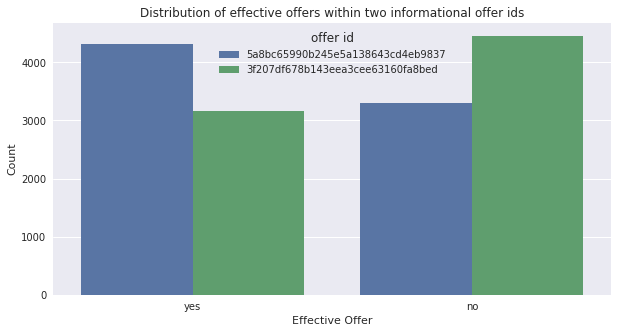

In [122]:
# effective offer distribution in offer id
plt.figure(figsize=(10, 5))
sns.countplot(x= "effective_offer", hue= "offer_id", data=df)
sns.set(style="whitegrid")
plt.title('Distribution of effective offers within two informational offer ids')
plt.ylabel('Count')
plt.xlabel('Effective Offer')
plt.legend(title='offer id')

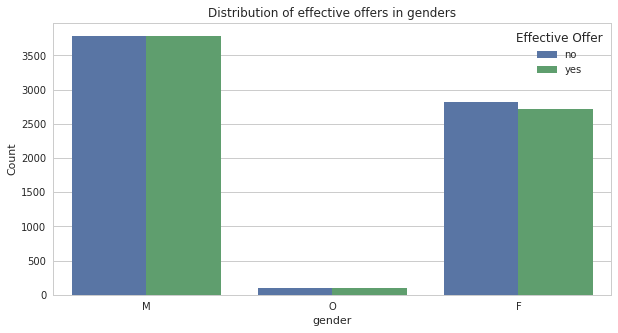

In [123]:
# effective offer distribution in gender
plt.figure(figsize=(10, 5))
sns.countplot(x= "gender", hue= "effective_offer", hue_order=['no','yes'],data=df)
sns.set(style="whitegrid")
plt.title('Distribution of effective offers in genders')
plt.ylabel('Count')
plt.xlabel('gender')
plt.legend(title='Effective Offer')

### Observation 10: About 50% of Male customers respond to an informational offer while Female customers slightly respond less.

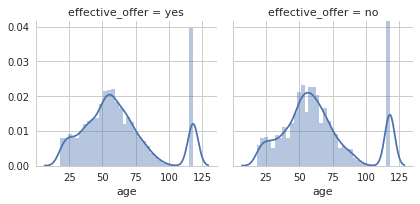

In [124]:
# income distribution by effective offer
fig = sns.FacetGrid(df, col='effective_offer', col_wrap=2)
fig.map(sns.distplot, 'age');

In [125]:
df['num_of_transactions']=df['num_of_transactions'].fillna(0)
df['gender'] = df['gender'].replace([None], ['unknown'], regex=True)
df['income']= df['income'].fillna(0)
df['tenure_day'] = df['tenure_day'].fillna(0)

In [126]:
#final dataset for bogo and discount offers:
df2=df.copy(deep=True)
df2.head()

,person,time,duration,email,mobile,social,web,age,gender,income,tenure_day,offer_id,effective_offer,num_of_transactions
0,0009655768c64bdeb2e877511632db8f,168,72.0,1.0,1.0,1.0,0.0,33,M,72000.0,1386,5a8bc65990b245e5a138643cd4eb9837,yes,1.0
1,0009655768c64bdeb2e877511632db8f,336,96.0,1.0,1.0,0.0,1.0,33,M,72000.0,1386,3f207df678b143eea3cee63160fa8bed,yes,1.0
2,0011e0d4e6b944f998e987f904e8c1e5,0,96.0,1.0,1.0,0.0,1.0,40,O,57000.0,1123,3f207df678b143eea3cee63160fa8bed,no,0.0
3,0011e0d4e6b944f998e987f904e8c1e5,336,72.0,1.0,1.0,1.0,0.0,40,O,57000.0,1123,5a8bc65990b245e5a138643cd4eb9837,no,0.0
4,0020c2b971eb4e9188eac86d93036a77,504,72.0,1.0,1.0,1.0,0.0,59,F,90000.0,1799,5a8bc65990b245e5a138643cd4eb9837,yes,2.0


In [127]:
df2=cleaning_profile(df2)
df2.head()

,person,time,duration,email,mobile,social,web,age,gender,income,tenure_day,offer_id,effective_offer,num_of_transactions,income_group,age_group,tenure_group
0,0009655768c64bdeb2e877511632db8f,168,72.0,1.0,1.0,1.0,0.0,33,M,72000.0,1386,5a8bc65990b245e5a138643cd4eb9837,yes,1.0,MiddleIncome,20-35,1250-1500
1,0009655768c64bdeb2e877511632db8f,336,96.0,1.0,1.0,0.0,1.0,33,M,72000.0,1386,3f207df678b143eea3cee63160fa8bed,yes,1.0,MiddleIncome,20-35,1250-1500
2,0011e0d4e6b944f998e987f904e8c1e5,0,96.0,1.0,1.0,0.0,1.0,40,O,57000.0,1123,3f207df678b143eea3cee63160fa8bed,no,0.0,MiddleIncome,35-50,1000-1125
3,0011e0d4e6b944f998e987f904e8c1e5,336,72.0,1.0,1.0,1.0,0.0,40,O,57000.0,1123,5a8bc65990b245e5a138643cd4eb9837,no,0.0,MiddleIncome,35-50,1000-1125
4,0020c2b971eb4e9188eac86d93036a77,504,72.0,1.0,1.0,1.0,0.0,59,F,90000.0,1799,5a8bc65990b245e5a138643cd4eb9837,yes,2.0,MiddleHighIncome,50-65,1500-2000


In [128]:
df2.isna().sum()

person                    0
time                      0
duration                  0
email                     0
mobile                    0
social                    0
web                       0
age                       0
gender                    0
income                    0
tenure_day                0
offer_id                  0
effective_offer           0
num_of_transactions       0
income_group              0
age_group                 0
tenure_group           1441
dtype: int64

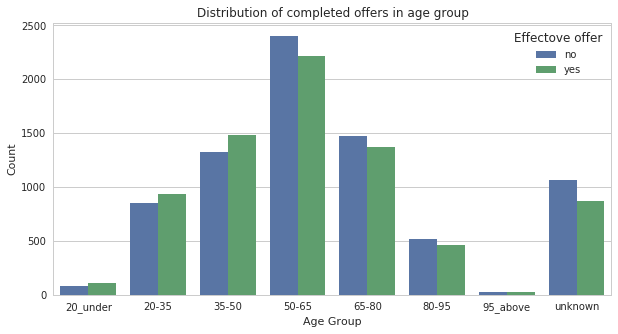

In [129]:
# completed offer distribution in offer type
plt.figure(figsize=(10, 5))
sns.countplot(x= "age_group", hue= 'effective_offer', hue_order=['no','yes'],data=df2,order=['20_under','20-35','35-50','50-65','65-80','80-95','95_above','unknown'])
sns.set(style="darkgrid")
plt.title('Distribution of completed offers in age group')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Effectove offer')

### Observation 11:  Customers with age under 50 respond to informational offers better.
### Observation 12: Customers who filled with age 118, 'unknown' here, respond to informational offers less.

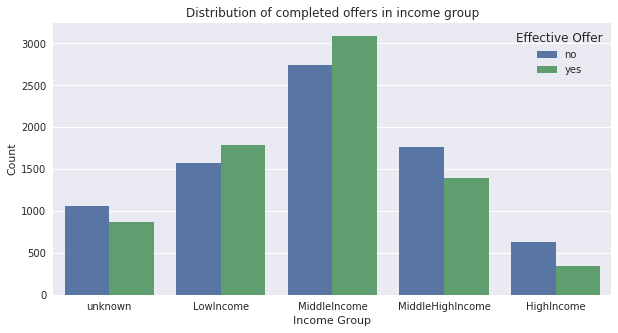

In [130]:
# completed offer distribution in offer type
plt.figure(figsize=(10, 5))
sns.countplot(x= "income_group", hue= 'effective_offer',hue_order=['no','yes'], data=df2, order=['unknown','LowIncome','MiddleIncome','MiddleHighIncome','HighIncome'])
sns.set(style="darkgrid")
plt.title('Distribution of completed offers in income group')
plt.ylabel('Count')
plt.xlabel('Income Group')
plt.legend(title='Effective Offer')

### Observation 13:  Customers with Low income and Middle income respond to informational offers better.

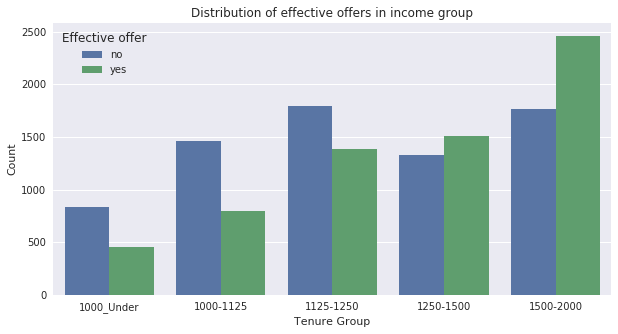

In [131]:
# completed offer distribution in offer type
plt.figure(figsize=(10, 5))
sns.countplot(x= "tenure_group", hue= 'effective_offer',hue_order=['no','yes'], data=df2, order=['1000_Under','1000-1125','1125-1250','1250-1500','1500-2000'])
sns.set(style="darkgrid")
plt.title('Distribution of effective offers in income group')
plt.ylabel('Count')
plt.xlabel('Tenure Group')
plt.legend(title='Effective offer')

### Observation 14: Customers with longer tenure respond to informational offers better. Especially for those customers who have more than 1250 tenure days.

## 2.3 Dataset Cleaning and feature engineering

In [132]:
df_flag=df.copy(deep=True)

In [133]:
# add number of offers received before current offer
df_flag["RANK"] = df.groupby(['person'])["time"].rank(method="first", ascending=True)
df_flag["Num_of_offer_received"]=df_flag["RANK"]-1.0

df_flag.head()

,person,time,duration,email,mobile,social,web,age,gender,income,tenure_day,offer_id,effective_offer,num_of_transactions,RANK,Num_of_offer_received
0,0009655768c64bdeb2e877511632db8f,168,72.0,1.0,1.0,1.0,0.0,33,M,72000.0,1386,5a8bc65990b245e5a138643cd4eb9837,yes,1.0,1.0,0.0
1,0009655768c64bdeb2e877511632db8f,336,96.0,1.0,1.0,0.0,1.0,33,M,72000.0,1386,3f207df678b143eea3cee63160fa8bed,yes,1.0,2.0,1.0
2,0011e0d4e6b944f998e987f904e8c1e5,0,96.0,1.0,1.0,0.0,1.0,40,O,57000.0,1123,3f207df678b143eea3cee63160fa8bed,no,0.0,1.0,0.0
3,0011e0d4e6b944f998e987f904e8c1e5,336,72.0,1.0,1.0,1.0,0.0,40,O,57000.0,1123,5a8bc65990b245e5a138643cd4eb9837,no,0.0,2.0,1.0
4,0020c2b971eb4e9188eac86d93036a77,504,72.0,1.0,1.0,1.0,0.0,59,F,90000.0,1799,5a8bc65990b245e5a138643cd4eb9837,yes,2.0,1.0,0.0


In [134]:
df_flag.Num_of_offer_received.max()

4.0

In [135]:
df_flag.shape

(15235, 16)

In [136]:
#check for class balance in datasets
print(df_flag[['person','effective_offer']].groupby('effective_offer').count()/len(df_flag))

                   person
effective_offer          
no               0.509091
yes              0.490909


In [137]:
#final dataset for bogo and discount offers:
df_infor=df_flag.drop(columns=['person','RANK'])

In [138]:
## Clean out None, NaN
df_infor['num_of_transactions']=df_infor['num_of_transactions'].fillna(0)
df_infor['gender'] = df_infor['gender'].replace([None], ['unknown'], regex=True)
df_infor['income']= df_infor['income'].fillna(0)

# split unique gender and offer_type to dummy variables 
df_infor= dummy(df_infor,'gender')

#Process offer_id column:
list_offer_ids = df_infor['offer_id'].unique().tolist()
offer_id_mapping = dict( zip(list_offer_ids,range(len(list_offer_ids))) )
df_infor.replace({'offer_id': offer_id_mapping},inplace=True)




#process numerical variables
#initialize a MinMaxScaler, then apply it to the numerical features
scaler = MinMaxScaler() # default=(0, 1)
num_cols = ['time', 'duration',  'age', 'income','tenure_day','Num_of_offer_received']
df_infor[num_cols] = scaler.fit_transform(df_infor[num_cols])

#encode 'completed_offer'  to numerical values 
df_infor['effective_offer'] = df['effective_offer'].map({'yes':1, 'no':0})
    
df_infor.head()

,time,duration,email,mobile,social,web,age,income,tenure_day,offer_id,effective_offer,num_of_transactions,Num_of_offer_received,gender_F,gender_M,gender_O,gender_unknown
0,0.291667,0.0,1.0,1.0,1.0,0.0,0.15,0.600,0.253019,0,1,1.0,0.00,0,1,0,0
1,0.583333,1.0,1.0,1.0,0.0,1.0,0.15,0.600,0.253019,1,1,1.0,0.25,0,1,0,0
2,0.000000,1.0,1.0,1.0,0.0,1.0,0.22,0.475,0.108672,1,0,0.0,0.00,0,0,1,0
3,0.583333,0.0,1.0,1.0,1.0,0.0,0.22,0.475,0.108672,0,0,0.0,0.25,0,0,1,0
4,0.875000,0.0,1.0,1.0,1.0,0.0,0.41,0.750,0.479693,0,1,2.0,0.00,1,0,0,0


## 2.4 Model Building


### 2.4.1 Model to predict if the offer would be effective 
          -Target variable: effective_offer

In [139]:
target = df_infor['effective_offer']
features = df_infor.drop(columns = ['effective_offer','num_of_transactions'],axis=1)

In [140]:
X_train,X_test,y_train, y_test=model_pipeline(features,target)

In [141]:
# random forest tree model:
#Initialize the model
model_rf_infor = RandomForestClassifier(random_state=42,max_depth= 10, max_features= 'auto',min_samples_split= 2,n_estimators=50,min_samples_leaf=2)
model_rf_train_f1, model_rf_test_f1, model_rf_model = Score(model_rf_infor,X_train, y_train, X_test, y_test)

training time: 0.4679
testing time: 0.1039
Training f1 score:72.7847
Test f1 score:61.4703
             precision    recall  f1-score   support

          0     0.6165    0.6341    0.6252      1544
          1     0.6127    0.5948    0.6036      1503

avg / total     0.6146    0.6147    0.6145      3047



In [142]:
# random forest tree model:
#Initialize the model
model_rf_infor = RandomForestClassifier(random_state=42,max_depth= 10, max_features= 'auto',min_samples_split= 2,n_estimators=200,min_samples_leaf=2)
model_rf_train_f1, model_rf_test_f1, model_rf_model = Score(model_rf_infor,X_train, y_train, X_test, y_test)

training time: 1.8615
testing time: 0.4077
Training f1 score:73.1047
Test f1 score:62.2908
             precision    recall  f1-score   support

          0     0.6244    0.6418    0.6330      1544
          1     0.6212    0.6035    0.6122      1503

avg / total     0.6229    0.6229    0.6228      3047



In [143]:
rf_param_selection(X_train, y_train)

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 25}

In [144]:
model_rf_infor = RandomForestClassifier(random_state=42,max_depth= 10, max_features= 'auto',min_samples_split= 2,n_estimators=200,min_samples_leaf=4)
model_rf_train_f1, model_rf_test_f1, model_rf_model = Score(model_rf_infor,X_train, y_train, X_test, y_test)

training time: 1.8356
testing time: 0.3967
Training f1 score:72.0135
Test f1 score:62.4221
             precision    recall  f1-score   support

          0     0.6246    0.6477    0.6359      1544
          1     0.6238    0.6001    0.6117      1503

avg / total     0.6242    0.6242    0.6240      3047



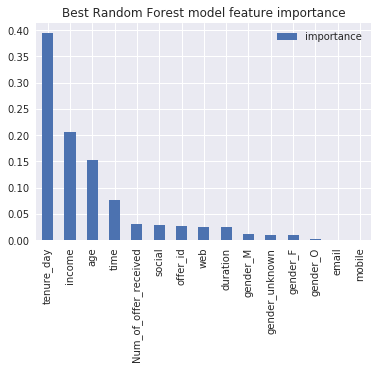

In [145]:
feature_importances = pd.DataFrame(model_rf_infor.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best Random Forest model feature importance')
plt.show()

### 2.4.2 Build model to predic how many transactions the offer would bring to an customer


In [146]:
target = df_infor['num_of_transactions']
features = df_infor.drop(columns = ['effective_offer','num_of_transactions'],axis=1)

In [147]:
X_train,X_test,y_train, y_test=model_pipeline(features,target)

In [148]:
# random forest tree model:
#Initialize the model
model_rf2 = RandomForestRegressor(random_state=42,max_depth= 10, n_estimators=100)
#model_rf2, model_rf2_test_f1, model_rf2_model = Score(model_rf2,X_train, y_train, X_test, y_test)

In [149]:
def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 200),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)
# Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=5, scoring='neg_mean_absolute_error')

    return scores

In [150]:
model_rf3=rfr_model(X_train, y_train)

In [151]:
model_rf3

array([-0.82618523, -0.8414899 , -0.80826294, -0.82403059, -0.83467586])

In [152]:

param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 50],
    'max_features': [2, 3],
    'min_samples_leaf': [2, 4],
    'min_samples_split': [2, 4, 10],
    'n_estimators': [50, 100, 200]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_



Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=2, min_samples

[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  4.4min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 200}

In [155]:
def evaluate(model, X_test, y_test):
    """ 
   {
   input:
        - model: trained model
        - X_test: features in test dataset
        - y_test: target variables in test dataset
   output:
        - model accuracy
        
    }
    """
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    #print(np.mean(y_test))
    #print('Accuracy = {:0.4f}%.'.format(mape))
    
    return accuracy

In [156]:
best_grid_model = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid_model, X_test, y_test)


Model Performance
Average Error: 0.8221 degrees.
